Used database: [github.com/CSSEGISandData/COVID-19](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/)<br>
First database: [kaggle.com/imdevskp/corona-virus-report](https://www.kaggle.com/imdevskp/corona-virus-report)<br>
Results of an analogous project: [life-xl.com/covid19.php](https://life-xl.com/covid19.php)

In [1]:
# Download the latest version of databases from the Internet and save to my disk

# !curl -o /media/l3m/LinuxFilesBig/1-datasets/COVID-19/COVID-19-confirmed.csv \
#          https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv

# !curl -o /media/l3m/LinuxFilesBig/1-datasets/COVID-19/COVID-19-deaths.csv \
#            https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv

# !curl -o /media/l3m/LinuxFilesBig/1-datasets/COVID-19/COVID-19-recovered.csv \
#          https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import math

PATH_DB = '/media/l3m/LinuxFilesBig/1-datasets/COVID-19/'

<br>

### Load and prepare data

In [3]:
# Load data from disk in Notebook
data_confirmed = pd.read_csv(PATH_DB+'COVID-19-confirmed.csv')
data_deaths = pd.read_csv(PATH_DB+'COVID-19-deaths.csv')
data_recovered = pd.read_csv(PATH_DB+'COVID-19-recovered.csv')

# rename some columns for convenience
for df in(data_confirmed, data_deaths, data_recovered):
    df.rename(columns={'Province/State': 'Province', 'Country/Region':'Country'}, inplace=True)

# check result
print(data_confirmed.shape)
print(data_deaths.shape)
print(data_recovered.shape)
data_confirmed.head(3)

(253, 71)
(253, 71)
(239, 71)


,Province,Country,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,22,24,24,40,40,74,84,94,110,110
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,64,70,76,89,104,123,146,174,186,197
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,87,90,139,201,230,264,302,367,409,454


In [4]:
# Transform tables to place Date in rows

data_confirmed = data_confirmed.set_index(['Province', 'Country', 'Lat', 'Long']) \
                               .stack() \
                               .reset_index() \
                               .rename(columns={'level_4':'Date', 0:'Confirmed'})

data_deaths = data_deaths.set_index(['Province', 'Country', 'Lat', 'Long']) \
                               .stack() \
                               .reset_index() \
                               .rename(columns={'level_4':'Date', 0:'Deaths'})

data_recovered = data_recovered.set_index(['Province', 'Country', 'Lat', 'Long']) \
                               .stack() \
                               .reset_index() \
                               .rename(columns={'level_4':'Date', 0:'Recovered'})

print(data_confirmed.shape)
data_confirmed.head(3)

(16951, 6)


,Province,Country,Lat,Long,Date,Confirmed
0,NaN,Afghanistan,33.0,65.0,1/22/20,0
1,NaN,Afghanistan,33.0,65.0,1/23/20,0
2,NaN,Afghanistan,33.0,65.0,1/24/20,0


In [5]:
# Convirt content of 'Date'-column to date format

for df in(data_confirmed, data_deaths, data_recovered):
    df['Date'] = pd.to_datetime(df['Date'])

# check result
print(data_confirmed.shape)
print(data_deaths.shape)
print(data_recovered.shape)
data_confirmed.head(3)

(16951, 6)
(16951, 6)
(16013, 6)


,Province,Country,Lat,Long,Date,Confirmed
0,NaN,Afghanistan,33.0,65.0,2020-01-22,0
1,NaN,Afghanistan,33.0,65.0,2020-01-23,0
2,NaN,Afghanistan,33.0,65.0,2020-01-24,0


<br>
At this moment data in recovered database are represented in a little different format. And since this data are not used furter, I ignore it.

In [6]:
# merge databases

assert len(data_confirmed) == len(data_deaths), \
    "DataFrames with have different sizes. Their merging can cause loss of data."

data_ac = data_confirmed.merge(data_deaths, on=['Province', 'Country', 'Lat', 'Long', 'Date'])

print(data_ac.shape)
data_ac.head(3)

(16951, 7)


,Province,Country,Lat,Long,Date,Confirmed,Deaths
0,NaN,Afghanistan,33.0,65.0,2020-01-22,0,0
1,NaN,Afghanistan,33.0,65.0,2020-01-23,0,0
2,NaN,Afghanistan,33.0,65.0,2020-01-24,0,0


In [7]:
# Combine data from different provinces for confirmed cases and deaths.
# Returned concised database with information only per countries.
# Datasets contain some difference in latitude and longitude,
# and since this information is insignificant for my goals, I omit them.

data_ac = data_ac.groupby(['Country', 'Date']) \
                 .agg({'Confirmed': 'sum',
                       'Deaths': 'sum'}) \
                 .reset_index()

print(data_ac.shape)
data_ac.head(3)

(11859, 4)


,Country,Date,Confirmed,Deaths
0,Afghanistan,2020-01-22,0,0
1,Afghanistan,2020-01-23,0,0
2,Afghanistan,2020-01-24,0,0


In [8]:
# Combine data from different provinces for recovered cases.
# Returned concised database with information only per countries.
# Datasets contain some difference in latitude and longitude,
# and since this information is insignificant for my goals, I omit them.

data_ac_recovered = data_recovered.groupby(['Country', 'Date']) \
                                  .agg({'Recovered': 'sum'}) \
                                  .reset_index()

print(data_ac_recovered.shape)
data_ac_recovered.head(3)

(11859, 3)


,Country,Date,Recovered
0,Afghanistan,2020-01-22,0
1,Afghanistan,2020-01-23,0
2,Afghanistan,2020-01-24,0


In [9]:
# Since concised databases have the same defining columns, we now can merge them in single datafram.
# Note, that in any of the previous operations there are no loss information about cases.

assert len(data_ac) == len(data_ac_recovered), \
    "DataFrames with have different sizes. Their merging can cause loss of data."

data_ac = data_ac.merge(data_ac_recovered, on=['Country', 'Date'])

print(data_ac.shape)
data_ac.head(3)

(11859, 5)


,Country,Date,Confirmed,Deaths,Recovered
0,Afghanistan,2020-01-22,0,0,0
1,Afghanistan,2020-01-23,0,0,0
2,Afghanistan,2020-01-24,0,0,0


In [10]:
# summarize data for world
data_world = data_ac.groupby('Date') \
                    .agg({'Country': lambda x: '_WORLD',
                          'Date': lambda x: x.iloc[0],
                          'Confirmed': 'sum',
                          'Deaths': 'sum',
                          'Recovered': 'sum'}).reset_index(drop=True)
data_world

,Country,Date,Confirmed,Deaths,Recovered
0,_WORLD,2020-01-22,555,17,28
1,_WORLD,2020-01-23,654,18,30
2,_WORLD,2020-01-24,941,26,36
3,_WORLD,2020-01-25,1434,42,39
4,_WORLD,2020-01-26,2118,56,52
...,...,...,...,...,...
62,_WORLD,2020-03-24,418045,18625,108000
63,_WORLD,2020-03-25,467653,21181,113787
64,_WORLD,2020-03-26,529591,23970,122150
65,_WORLD,2020-03-27,593291,27198,130915


In [11]:
# Add data about the world at large in global dataframe
data_ac = pd.concat([data_ac, data_world]) \
            .reset_index(drop=True)

data_ac

,Country,Date,Confirmed,Deaths,Recovered
0,Afghanistan,2020-01-22,0,0,0
1,Afghanistan,2020-01-23,0,0,0
2,Afghanistan,2020-01-24,0,0,0
3,Afghanistan,2020-01-25,0,0,0
4,Afghanistan,2020-01-26,0,0,0
...,...,...,...,...,...
11921,_WORLD,2020-03-24,418045,18625,108000
11922,_WORLD,2020-03-25,467653,21181,113787
11923,_WORLD,2020-03-26,529591,23970,122150
11924,_WORLD,2020-03-27,593291,27198,130915


<br>

### Countries with the highest numbers of confirmed cases

In [12]:
# Create additional DataFrame, containing only information about total cases
total_cases = data_ac.groupby('Country') \
                     .apply(lambda gr: gr.iloc[-1]) \
                     .reset_index(drop=True)

total_cases

,Country,Date,Confirmed,Deaths,Recovered
0,Afghanistan,2020-03-28,110,4,2
1,Albania,2020-03-28,197,10,31
2,Algeria,2020-03-28,454,29,31
3,Andorra,2020-03-28,308,3,1
4,Angola,2020-03-28,5,0,0
...,...,...,...,...,...
173,Vietnam,2020-03-28,174,0,21
174,West Bank and Gaza,2020-03-28,98,1,18
175,Zambia,2020-03-28,28,0,0
176,Zimbabwe,2020-03-28,7,1,0


In [13]:
total_cases = total_cases.sort_values(by='Confirmed', ascending=False) \
                         .reset_index(drop=True)

# Show total statistics for world and countries with the highest numbers of confirmed cases
total_cases.head(60)

,Country,Date,Confirmed,Deaths,Recovered
0,_WORLD,2020-03-28,660706,30652,139415
1,US,2020-03-28,121478,2026,1072
2,Italy,2020-03-28,92472,10023,12384
3,China,2020-03-28,81999,3299,75100
4,Spain,2020-03-28,73235,5982,12285
5,Germany,2020-03-28,57695,433,8481
6,France,2020-03-28,38105,2317,5724
7,Iran,2020-03-28,35408,2517,11679
8,United Kingdom,2020-03-28,17312,1021,151
9,Switzerland,2020-03-28,14076,264,1530


<br>

### Create a table revealing of new cases

In [14]:
# Till now DataFrame contains total number of cases.
# Change it to the number of new cases per day (calculate it as difference b/w neighbouring rows)

data_dynamics = pd.concat([data_ac[['Country', 'Date']],
                           data_ac[['Confirmed', 'Deaths', 'Recovered']].diff()
                          ], axis='columns') \
                  .reset_index(drop=True)

print(data_dynamics.shape)
data_dynamics.head(3)

(11926, 5)


,Country,Date,Confirmed,Deaths,Recovered
0,Afghanistan,2020-01-22,NaN,NaN,NaN
1,Afghanistan,2020-01-23,0.0,0.0,0.0
2,Afghanistan,2020-01-24,0.0,0.0,0.0


In [15]:
# Now the first row (earliest day of observatopm) for each country contains garbage.
# So, delete the earliest data for each country

def delete_earliest_data(gr):
    gr.drop(gr.index[0], inplace=True)
    return gr
    
data_dynamics = data_dynamics.groupby(['Country']) \
                             .apply(delete_earliest_data) \
                             .reset_index(drop=True)

# Correct type of some columns back to int
data_dynamics[['Confirmed', 'Deaths', 'Recovered']] = \
    data_dynamics[['Confirmed', 'Deaths', 'Recovered']].astype('int')

print(data_dynamics.shape)
data_dynamics.head(3)

(11748, 5)


,Country,Date,Confirmed,Deaths,Recovered
0,Afghanistan,2020-01-23,0,0,0
1,Afghanistan,2020-01-24,0,0,0
2,Afghanistan,2020-01-25,0,0,0


<br>

### Create graphs

In [16]:
LAST_DATE_GLOBAL = data_ac['Date'].max()  # last_date = datetime.datetime(2020, 3, 25)
NUMBER_OF_DAYS_GLOBAL = 30

In [17]:
def extract_df(df_overall, country_name=None, last_date=datetime.datetime.now(), number_of_days=90):
    """Extract from overall DataFrame sub-DataFrame according given limitations.
    
    :df_overall:     overall (big) DataFrame
    :country_name:   name of country
    :last_date:      last date till that the graph will be shown
    :number_of_days: number of days in the graph
    :return:         sub-DateFrame
    """
    first_date = last_date + datetime.timedelta(days=-number_of_days+1)

    if country_name:
        sub_df = df_overall[(df_overall['Country'] == country_name) &
                            (df_overall['Date'] >= first_date) &
                            (df_overall['Date'] <= last_date)]
    else:
        sub_df = df_overall[(df_overall['Date'] >= first_date) &
                            (df_overall['Date'] <= last_date)]

    return sub_df    

In [18]:
def build_graph(df, *, title_text=None):
    # create index to set proper appearance of x-axis
    df.index = df['Date'].dt.strftime('%b-%d')
    
    # remove label 'Date' from the x-axis
    df.rename_axis(None, axis='rows', inplace=True)
    
    df['Confirmed'].plot(kind='bar', width=1, title=title_text,
                         color=['#C07800', '#D0810F'], figsize=(20,6), fontsize=14)
    
    return None

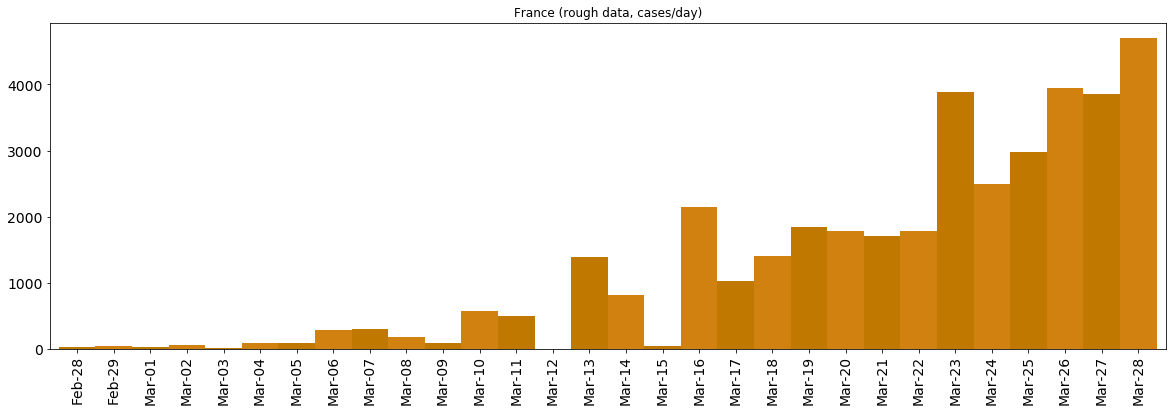

In [19]:
# Build graph for a separate country.
# Set country, the last day of shown results, and the number of days for showing

country_name = 'France'
last_date = LAST_DATE_GLOBAL
number_of_days = NUMBER_OF_DAYS_GLOBAL

country_graph = extract_df(data_dynamics, country_name, last_date, number_of_days)

build_graph(country_graph, title_text=country_name+' (rough data, cases/day)')

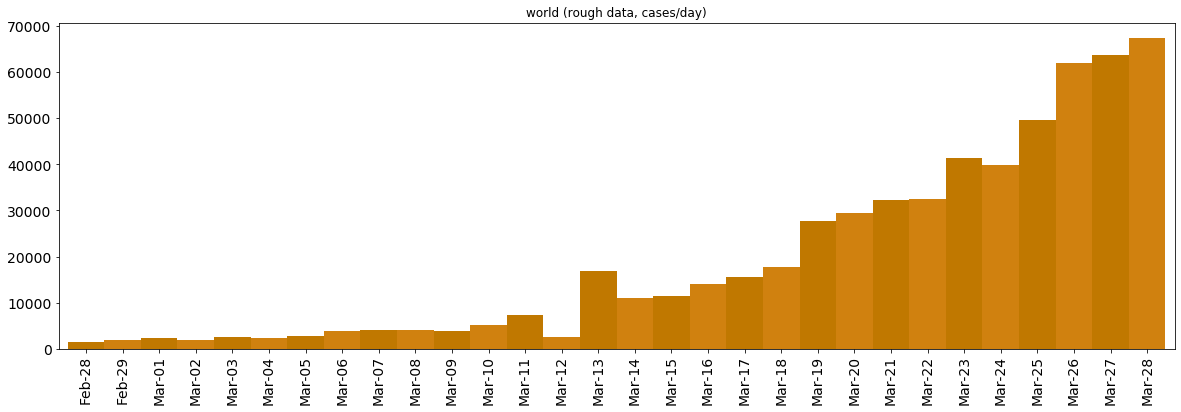

In [20]:
# build graph for the world

last_date = LAST_DATE_GLOBAL
number_of_days = NUMBER_OF_DAYS_GLOBAL

world_graph = extract_df(data_dynamics, '_WORLD', last_date, number_of_days)

build_graph(world_graph, title_text='world (rough data, cases/day)')

<br>

### Create smoothed graphs

We can see in the graphs that occasionally a day of high revealing of infection adjoins with a day of low revealing. I suggest to smooth the data, taking for each day an average value between three adjacent days.

In [21]:
def smooth_df(df):
    
    def smooth_column_values(column):
        ls = list(column)
        lng = len(ls)

        smoothed_values = [] 
        
        smoothed_values.append(round((ls[0]*2 + ls[1]) / 3, 2))
        smoothed_values.extend([round((ls[i-1] + ls[i] + ls[i+1]) / 3, 2) for i in range(1, lng-1)])
        smoothed_values.append(round((ls[lng-2] + ls[lng-1]*2) / 3, 2))
    
        return smoothed_values

    df_smoothed = df.copy()
    for col_name in ['Confirmed', 'Deaths', 'Recovered']:
        df_smoothed[col_name] = smooth_column_values(df_smoothed[col_name])
        
    return df_smoothed

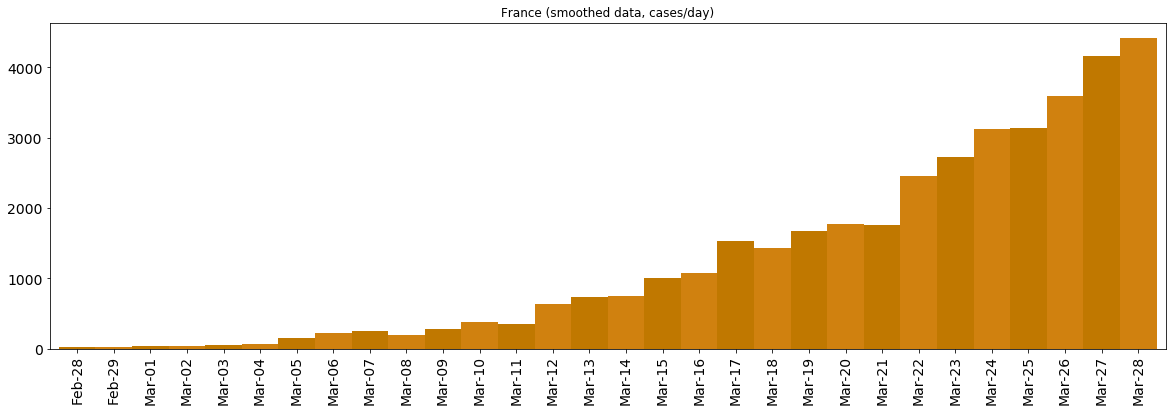

In [22]:
# Create smoothed graph for a separate country

country_name = 'France'
last_date = LAST_DATE_GLOBAL
number_of_days = NUMBER_OF_DAYS_GLOBAL

country_smoothed = smooth_df(extract_df(data_dynamics, country_name, last_date, number_of_days))

build_graph(country_smoothed, title_text=country_name+' (smoothed data, cases/day)')

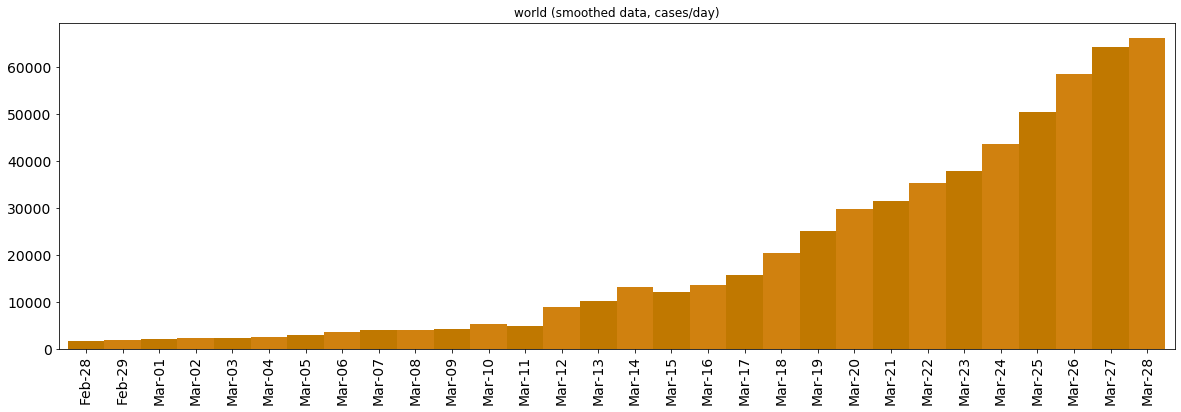

In [23]:
# Create smoothed graph for the world
last_date = LAST_DATE_GLOBAL
number_of_days = NUMBER_OF_DAYS_GLOBAL

world_smoothed = smooth_df(extract_df(data_dynamics, '_WORLD', last_date, number_of_days))

build_graph(world_smoothed, title_text='world (smoothed data, cases/day)')

<br>

### Comparison of several countries

In [24]:
plt.rcParams['figure.figsize'] = (20, 6)  # plt.rc('figure', figsize=(20, 6))
plt.rcParams['font.size'] = 14            # plt.rc('font', size=14)

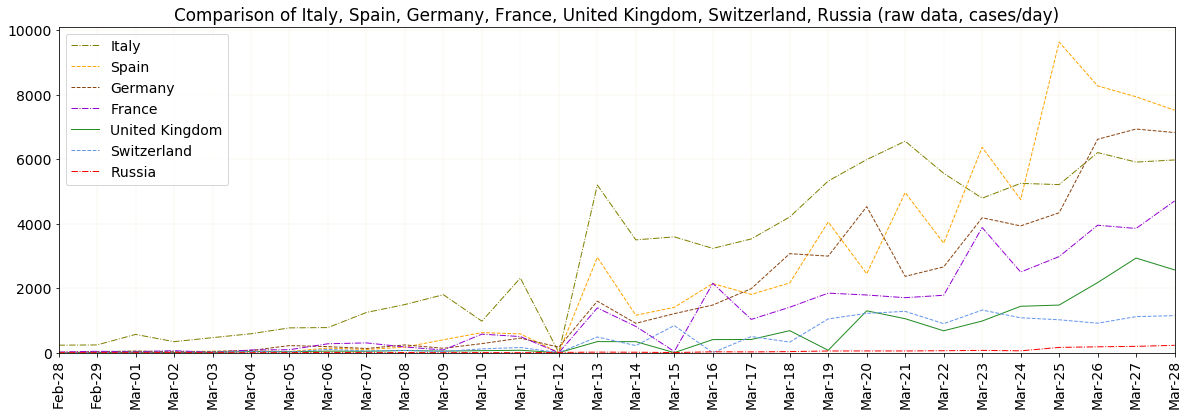

In [25]:
# for raw data, linear scale

countries = ['Italy', 'Spain', 'Germany', 'France', 'United Kingdom', 'Switzerland', 'Russia']
colors = ['olive', 'orange', 'saddlebrown', 'darkviolet', 'forestgreen', 'cornflowerblue', 'red']
styles = ['-.', '--', '--', '-.', '-', '--', '-.']

last_date = LAST_DATE_GLOBAL
number_of_days = NUMBER_OF_DAYS_GLOBAL

for i, country_name in enumerate(countries):
    country_graph = extract_df(data_dynamics, country_name, last_date, number_of_days)
    plt.plot(country_graph['Date'].dt.strftime('%b-%d'), country_graph['Confirmed'],
             color=colors[i], linestyle=styles[i], linewidth=1, label=country_name)

plt.xticks(rotation='vertical')
plt.grid(color='wheat', linewidth=0.2)
plt.legend(loc='upper left')
    
plt.title(f"Comparison of {', '.join(countries)} (raw data, cases/day)")
plt.margins(x=0)
plt.ylim(0)

plt.show()

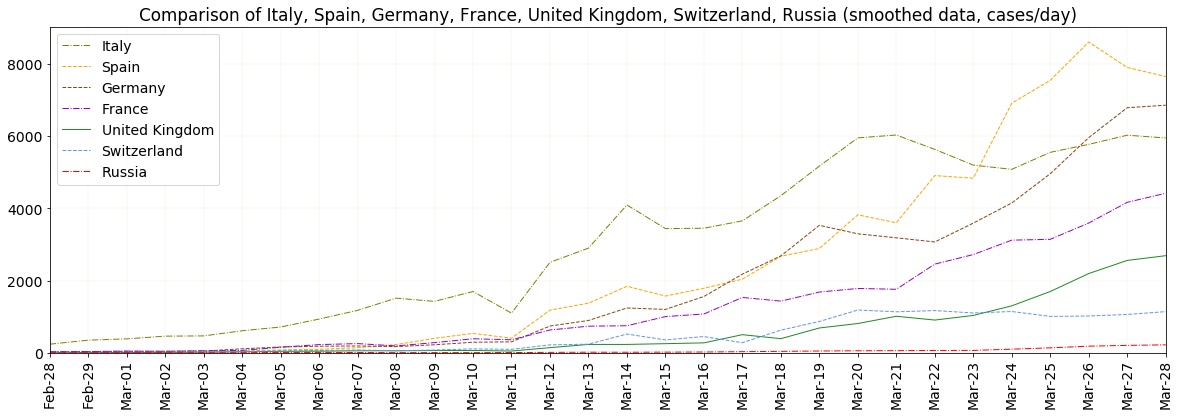

In [26]:
# for smoothed data, linear scale

countries = ['Italy', 'Spain', 'Germany', 'France', 'United Kingdom', 'Switzerland', 'Russia']
colors = ['olive', 'orange', 'saddlebrown', 'darkviolet', 'forestgreen', 'cornflowerblue', 'red']
styles = ['-.', '--', '--', '-.', '-', '--', '-.']

last_date = LAST_DATE_GLOBAL
number_of_days = NUMBER_OF_DAYS_GLOBAL

for i, country_name in enumerate(countries):
    country_graph = extract_df(data_dynamics, country_name, last_date, number_of_days)
    southed_graph = smooth_df(country_graph)
    plt.plot(southed_graph['Date'].dt.strftime('%b-%d'), southed_graph['Confirmed'],
             color=colors[i], linestyle=styles[i], linewidth=1, label=country_name)

plt.xticks(rotation='vertical')
plt.grid(color='wheat', linewidth=0.2)
plt.legend(loc='upper left')

plt.title(f"Comparison of {', '.join(countries)} (smoothed data, cases/day)")
plt.margins(x=0)
plt.ylim(0)

plt.show()

In [27]:
# Service function for calculation of line frequency at the graph grid for logarithmic scale.

def calculate_logarithmic_ticks(min_value=1, max_value=10**10):
    ticks = []
    max_power = math.ceil(math.log10(max_value))
    min_power = math.floor(math.log10(min_value)) if min_value > 0 else 0
    
    for t in range(1, max_power+1):
        m = 10 ** t
        if m == 10:
            ticks.extend([2.5, 5, 7.5, 10])
        else:
            ticks.extend([m//4, m//2, m//4*3, m])

    ticks = list(filter(lambda n: (n >= min_value) & (n <= max_value), ticks))
    
    return ticks

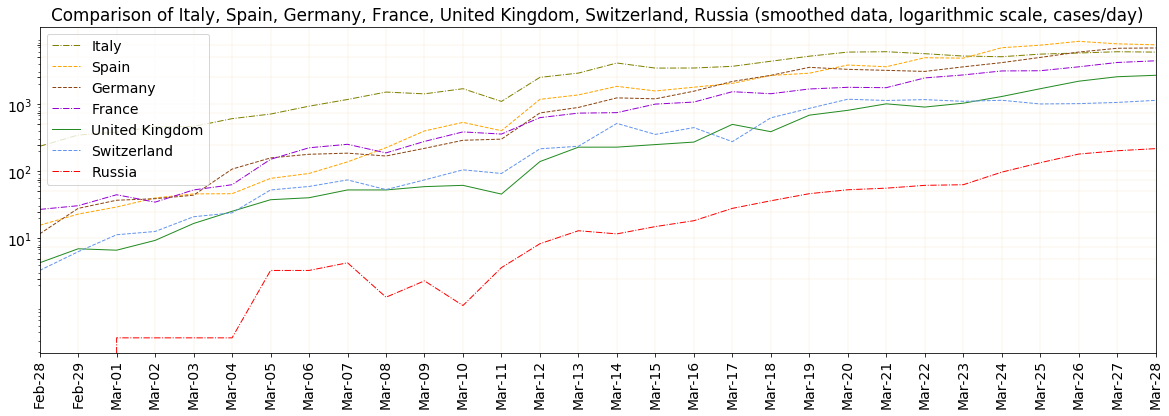

In [28]:
# logarithmic scale, smoothed data

countries = ['Italy', 'Spain', 'Germany', 'France', 'United Kingdom', 'Switzerland', 'Russia']
colors = ['olive', 'orange', 'saddlebrown', 'darkviolet', 'forestgreen', 'cornflowerblue', 'red']
styles = ['-.', '--', '--', '-.', '-', '--', '-.']

last_date = LAST_DATE_GLOBAL
number_of_days = NUMBER_OF_DAYS_GLOBAL

rate_min = math.inf  # service variables, don't change them
rate_max = 0

for i, country_name in enumerate(countries):
    country_graph = extract_df(data_dynamics, country_name, last_date, number_of_days)
    southed_graph = smooth_df(country_graph)
    
    rate_min_current = country_graph['Confirmed'].min()
    if rate_min_current < rate_min:
        rate_min = rate_min_current
        
    rate_max_current = country_graph['Confirmed'].max()
    if rate_max_current > rate_max:
        rate_max = rate_max_current
    
    plt.plot(southed_graph['Date'].dt.strftime('%b-%d'), southed_graph['Confirmed'],
             color=colors[i], linestyle=styles[i], linewidth=1, label=country_name)

plt.xticks(rotation='vertical')
plt.grid(color='wheat', linewidth=0.2)
plt.legend(loc='upper left')

plt.title(f"Comparison of {', '.join(countries)}"
           " (smoothed data, logarithmic scale, cases/day)")

plt.margins(x=0)

plt.grid(color='wheat', linewidth=0.25)

plt.yscale('log')
labels_y = calculate_logarithmic_ticks(rate_min, rate_max)
plt.yticks(labels_y)

plt.show()

<br>

### Comparison of dynamics after the first n confirmed cases
(*beginning from the day than this limit was achieved*)<br>
Caution: don't use China for this conparison since the table doesn't contain information about the first cases in this country.

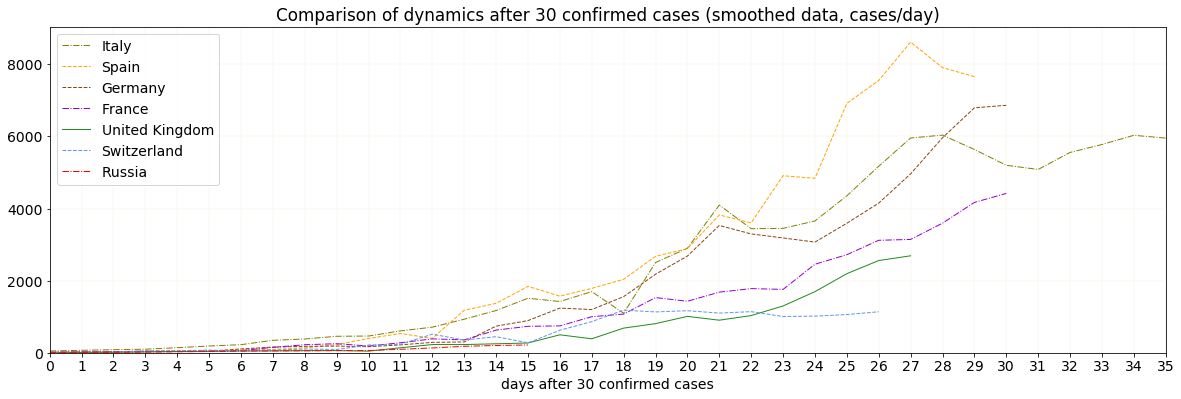

In [29]:
# used smoothed data, linear scale

countries = ['Italy', 'Spain', 'Germany', 'France', 'United Kingdom', 'Switzerland', 'Russia']
colors = ['olive', 'orange', 'saddlebrown', 'darkviolet', 'forestgreen', 'cornflowerblue', 'red']
styles = ['-.', '--', '--', '-.', '-', '--', '-.']

MIN_LIMIT = 30

max_lng = 0  # service variable, don't change it

for i, country in enumerate(countries):
    min_date = data_ac[(data_ac['Country'] == country) & ((data_ac['Confirmed'] >= MIN_LIMIT))]['Date'].min()
    
    country_graph = smooth_df(data_dynamics[data_dynamics['Country'] == country])
    country_graph = country_graph[country_graph['Date'] >= min_date].reset_index(drop=True)
    if len(country_graph) > max_lng:
        max_lng = len(country_graph)
    plt.plot(country_graph.index, country_graph['Confirmed'],
             color=colors[i], linestyle=styles[i], linewidth=1, label=country)
    
plt.margins(x=0)
plt.ylim(0)

labels = range(max_lng)
plt.xticks(labels)
plt.grid(color='wheat', linewidth=0.2)

plt.title(f'Comparison of dynamics after {MIN_LIMIT} confirmed cases (smoothed data, cases/day)')
plt.legend()
plt.xlabel(f'days after {MIN_LIMIT} confirmed cases')

plt.show()

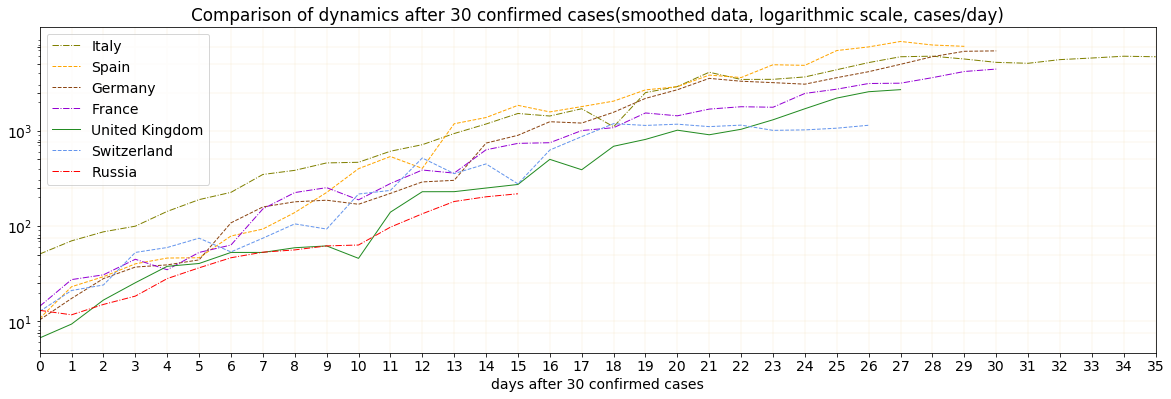

In [30]:
# used smoothed data, logarithmic scale

countries = ['Italy', 'Spain', 'Germany', 'France', 'United Kingdom', 'Switzerland', 'Russia']
colors = ['olive', 'orange', 'saddlebrown', 'darkviolet', 'forestgreen', 'cornflowerblue', 'red']
styles = ['-.', '--', '--', '-.', '-', '--', '-.']

MIN_LIMIT = 30

max_lng = 0           # service variables, don't change them
rate_min = math.inf
rate_max = 0

for i, country in enumerate(countries):
    min_date = data_ac[(data_ac['Country'] == country) & ((data_ac['Confirmed'] >= MIN_LIMIT))]['Date'].min()
    
    country_graph = smooth_df(data_dynamics[data_dynamics['Country'] == country])
    country_graph = country_graph[country_graph['Date'] >= min_date].reset_index(drop=True)
    
    if len(country_graph) > max_lng:
        max_lng = len(country_graph)
        
    rate_min_current = country_graph['Confirmed'].min()
    if rate_min_current < rate_min:
        rate_min = rate_min_current
        
    rate_max_current = country_graph['Confirmed'].max()
    if rate_max_current > rate_max:
        rate_max = rate_max_current
        
    plt.plot(country_graph.index, country_graph['Confirmed'],
             color=colors[i], linestyle=styles[i], linewidth=1, label=country)
    
plt.margins(x=0)
plt.yscale('log')

labels = range(max_lng)
plt.xticks(labels)

plt.title(f'Comparison of dynamics after {MIN_LIMIT} confirmed cases' \
           '(smoothed data, logarithmic scale, cases/day)')
plt.legend()
plt.xlabel(f'days after {MIN_LIMIT} confirmed cases')

plt.grid(color='wheat', linewidth=0.25)

labels_y = calculate_logarithmic_ticks(rate_min, rate_max)
plt.yticks(labels_y)

plt.show()

<br>

In [31]:
# countries = ['Italy', 'Spain', 'Germany', 'France', 'United Kingdom', 'Switzerland', 'Russia']
# colors = ['olive', 'orange', 'saddlebrown', 'darkviolet', 'forestgreen', 'cornflowerblue', 'red']
# styles = ['-.', '--', '--', '-.', '-', '--', '-.']

# countries = ['Korea, South', 'Malaysia', 'Japan', 'Thailand', 'Indonesia', 'India', 'Russia']
# colors = ['peru', 'darkolivegreen', 'gold', 'slateblue', 'rebeccapurple', 'yellowgreen', 'red']
# styles = ['--', ':', '-', '--', '-.', '-', '-.']

# countries = ['US', 'Canada', 'Brazil', 'Chile', 'Ecuador', 'Mexico', 'Russia']
# colors = ['blue', 'darkgray', 'limegreen', 'darkgoldenrod', 'orange', 'gold', 'red']
# styles = ['-.', ':', '-', '--', '-.', '-', '-.']

# countries = ['US', 'Italy', 'China', 'Spain', 'Germany', 'France', 'Korea, South']
# colors = ['blue', 'olive', 'limegreen', 'orange', 'saddlebrown', 'darkviolet', 'peru']
# styles = ['-.', '-.', '-', '--', '--', '-.', ':']